<a href="https://colab.research.google.com/github/Tokisaki-Galaxy/PterygiumSeg/blob/master/work1_basemodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 导入必要的库
导入PyTorch、OpenCV、Pandas等必要的库，为图像分类模型做准备。

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
from torchvision import transforms, models
import pandas as pd
import os
from PIL import Image
import platform
import random
import numpy as np
import glob
from tqdm.autonotebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager

if platform.system() == "Windows":
    num_workers = 0
    print(f"检测到 Windows 系统，将 DataLoader 的 num_workers 设置为 {num_workers}。")
else:
    # 在非 Windows 系统（如 Linux/Colab）上
    num_workers = 4
    print(f"检测到非 Windows 系统 ({platform.system()})，将 DataLoader 的 num_workers 设置为 {num_workers}。")
    # 设置中文字体
    if not os.path.exists('simhei.ttf'):
        !wget -O simhei.ttf "https://cdn.jsdelivr.net/gh/Haixing-Hu/latex-chinese-fonts/chinese/%E9%BB%91%E4%BD%93/SimHei.ttf"
    matplotlib.font_manager.fontManager.addfont('simhei.ttf')
    matplotlib.rc('font', family='SimHei')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ================== 数据集路径 =================
# 数据路径
image_dir =          r"f:/train"
# colab路径
colab_zip_path = "/content/drive/My Drive/train.zip"
colab_extract_path = "/content/trains/"
# Kaggle路径
#kaggle_zip_path = "/kaggle/working/train.zip"
#kaggle_extract_path = "/kaggle/working/trains/"
kaggle_extract_path = "/kaggle/input/pterygium/train/"
kaggle_temp_path = "/kaggle/working/"

# =================== 验证集路径 =================
# 验证集路径
val_image_dir =      r"f:/val"
# colab路径
#colab_val_zip_path = "/content/drive/My Drive/val.zip"
#colab_val_extract_path = "/content/val/"
# Kaggle路径
kaggle_val_path = "/kaggle/input/pterygium/val_img/"

# 配置GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA 可用: {torch.cuda.is_available()}")
print(f"使用的设备: {device}")

if torch.cuda.is_available():
    cudnn.benchmark = True
    print("cuDNN benchmark 模式已启用")

检测到非 Windows 系统 (Linux)，将 DataLoader 的 num_workers 设置为 4。
--2025-04-13 01:53:55--  https://cdn.jsdelivr.net/gh/Haixing-Hu/latex-chinese-fonts/chinese/%E9%BB%91%E4%BD%93/SimHei.ttf
Resolving cdn.jsdelivr.net (cdn.jsdelivr.net)... 151.101.129.229, 151.101.193.229, 151.101.1.229, ...
Connecting to cdn.jsdelivr.net (cdn.jsdelivr.net)|151.101.129.229|:443... connected.
HTTP request sent, awaiting response... 

/tmp/ipykernel_19/1930298697.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


200 OK
Length: 9751960 (9.3M) [font/ttf]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.30M  --.-KB/s    in 0.1s    

2025-04-13 01:53:56 (97.0 MB/s) - ‘simhei.ttf’ saved [9751960/9751960]

CUDA 可用: True
使用的设备: cuda
cuDNN benchmark 模式已启用


# 读取和准备数据
从train_classification_label.xlsx读取标签数据，并组织预处理后的图像数据路径。标签包括：0（健康）、1（建议观察）、2（建议手术）。

In [2]:
import zipfile
import sys

# 如果在云端上运行，从 Google Drive 读取数据
if 'google.colab' in sys.modules or os.path.exists("/kaggle/working"):

    if 'google.colab' in sys.modules:
        print('在 Google Colab 环境中运行')
        image_dir = os.path.join(colab_extract_path,"train")
        label_file = os.path.join(image_dir,"train_classification_label.xlsx")
        zip_path = colab_zip_path
        extract_path = colab_extract_path

        # Mount Google Drive
        from google.colab import drive
        drive.mount('/content/drive')
    else:
        print('在 Kaggle 环境中运行')
        # Kaggle 环境下的路径设置
        # image_dir = os.path.join(kaggle_extract_path,"train")
        # label_file = os.path.join(image_dir,"train_classification_label.xlsx")
        # zip_path = kaggle_zip_path
        # extract_path = kaggle_extract_path

        # Google Drive 有每日下载次数限制，可能会导致下载失败
        # if not os.path.exists(zip_path):
        #     from kaggle_secrets import UserSecretsClient
        #     user_secrets = UserSecretsClient()
        #     !gdown --id {user_secrets.get_secret("train_zip_downloadurl")}
        image_dir = os.path.join(kaggle_extract_path,"train")
        label_file = os.path.join(image_dir,"train_classification_label.xlsx")
        val_image_dir = os.path.join(kaggle_val_path,"val_img")

    if not os.path.exists(label_file):
        # 解压数据
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)    
else:
    print(f'不在云端环境中运行,使用本地数据路径{image_dir}')
label_file = os.path.join(image_dir,"train_classification_label.xlsx")

# 自定义数据集类，用于读取图像和标签
class PterygiumDataset(Dataset):
    def __init__(self, label_file, image_dir, transform=None):
        """
        初始化数据集
        :param label_file: 包含图像标签的Excel文件路径
        :param image_dir: 图像文件夹路径
        :param transform: 图像变换操作
        """
        self.labels_df = pd.read_excel(label_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        获取指定索引的图像和标签
        :param idx: 索引
        :return: 图像张量和对应标签
        """
        row = self.labels_df.iloc[idx]
        image_name = row['Image']
        label = row['Pterygium']
        image_folder = f"{int(image_name):04d}"
        image_path = os.path.join(self.image_dir, image_folder, f"{image_folder}.png")

        # 加载图像
        image = Image.open(image_path).convert("RGB")

        # 应用图像变换
        if self.transform:
            image = self.transform(image)

        return image, label

在 Kaggle 环境中运行


# 数据 Resize
这一步骤是将图像调整为224x224的大小，以适应模型输入要求。
只在Linux运行时使用，因为windows仅用与测试。

In [3]:
from torchvision.transforms.functional import to_pil_image
target_size = (224, 224) # 目标尺寸
output_format = "PNG" # 输出格式

# --- Transformation Definition ---
# We will perform Resize on GPU. ToTensor conversion happens before moving to GPU.
# Normalization will be done *online* during training dataloading, not offline.
resize_transform = transforms.Resize(target_size, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)
# BILINEAR is a good default. antialias=True is recommended for downsampling.

# --- Processing Function ---
def resize_and_save_image(img_info, base_input_dir, base_output_dir, transform, device):
    """
    Reads an image, resizes it (potentially on GPU), and saves it.
    """
    try:
        image_name = img_info['Image']
        image_name = f"{int(image_name):04d}"
        if os.path.exists(os.path.join(base_input_dir, f"{image_name}.png")):
            # 验证集图像路径
            input_path = os.path.join(base_input_dir, f"{image_name}.png")
            os.makedirs(base_output_dir, exist_ok=True)
            output_path = os.path.join(base_output_dir, f"{image_name}.{output_format.lower()}")
        else:
            # 训练集图像路径
            input_path = os.path.join(base_input_dir, image_name, f"{image_name}.png")
            # Create corresponding output subdirectory if it doesn't exist
            output_folder_path = os.path.join(base_output_dir, image_name)
            os.makedirs(output_folder_path, exist_ok=True)
            output_path = os.path.join(output_folder_path, f"{image_name}.{output_format.lower()}")

        # 1. Read image using PIL (CPU)
        img_pil = Image.open(input_path).convert("RGB")

        # 2. Convert PIL image to Tensor (CPU, scales to [0, 1])
        img_tensor_cpu = transforms.functional.to_tensor(img_pil) # Output: CxHxW

        # 3. Move tensor to GPU (if available)
        img_tensor_gpu = img_tensor_cpu.to(device)

        # 4. Apply Resize transform (GPU)
        resized_tensor_gpu = transform(img_tensor_gpu)

        # 5. Move resized tensor back to CPU
        resized_tensor_cpu = resized_tensor_gpu.cpu()

        # 6. Convert tensor back to PIL Image (CPU)
        # to_pil_image expects CxHxW tensor in [0, 1] range
        resized_img_pil = to_pil_image(resized_tensor_cpu)

        # 7. Save the resized PIL image (CPU)
        resized_img_pil.save(output_path, format=output_format)
        
        return True # Indicate success

    except FileNotFoundError:
        print(f"错误: 文件未找到 {input_path}")
        return False
    except Exception as e:
        print(f"错误处理图像 {input_path}: {e}")
        return False

if not platform.system() == "Windows":
    if 'google.colab' in sys.modules:
        original_image_dir = os.path.join(colab_extract_path,"train")
        output_dir = os.path.join(colab_extract_path,"train_resized")
    elif os.path.exists("/kaggle/working"):
        original_image_dir = os.path.join(kaggle_extract_path,"train")
        output_dir = os.path.join(kaggle_temp_path,"train_resized")
    else:
        print("错误: 无法识别的环境")
        exit(1)
    image_dir = output_dir

    print(f"输入目录: {original_image_dir}")
    print(f"输出目录: {output_dir}")
    print(f"目标尺寸: {target_size}")

    # Create the main output directory
    os.makedirs(output_dir, exist_ok=True)
    if os.listdir(output_dir):
        print("检测到已存在的resize数据，跳过resize步骤")
    else:
        # Read label file to know which images to process
        try:
            labels_df = pd.read_excel(label_file)
        except FileNotFoundError:
            print(f"错误: 标签文件未找到 {label_file}")
            sys.exit(1) # Exit if label file is missing

        success_count = 0
        error_count = 0

        # Iterate through images listed in the label file
        for index, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Resizing Images"):
            if resize_and_save_image(row, original_image_dir, output_dir, resize_transform, device):
                success_count += 1
            else:
                error_count += 1

        print(f"\n处理完成!")
        print(f"成功处理图像数: {success_count}")
        print(f"处理失败图像数: {error_count}")
        print(f"处理后的图像保存在: {output_dir}")

输入目录: /kaggle/input/pterygium/train/train
输出目录: /kaggle/working/train_resized
目标尺寸: (224, 224)


Resizing Images:   0%|          | 0/450 [00:00<?, ?it/s]


处理完成!
成功处理图像数: 450
处理失败图像数: 0
处理后的图像保存在: /kaggle/working/train_resized


# 创建数据加载器
使用PyTorch的Dataset和DataLoader类创建数据集和加载器，包括数据增强和训练/验证集的划分。

In [4]:
# 数据变换
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # 先放大一点
    transforms.RandomCrop((224, 224)), # 随机裁剪回目标尺寸
    transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
    transforms.RandomRotation(degrees=15), # 随机旋转
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # 随机颜色抖动
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义验证集/测试集的变换 (无需数据增强)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 划分训练集和验证集，并创建对应的数据加载器
from sklearn.model_selection import train_test_split

# 读取标签文件
labels_df = pd.read_excel(label_file)

# 按照8:2的比例划分训练集和验证集
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['Pterygium'])

# 保存划分后的数据集到文件
train_label_file = os.path.join(image_dir, "train_classification_label_train.xlsx")
val_label_file = os.path.join(image_dir, "train_classification_label_val.xlsx")
if os.path.exists("/kaggle/working"):
    train_label_file = os.path.join(kaggle_temp_path, "train_classification_label_train.xlsx")
    val_label_file = os.path.join(kaggle_temp_path, "train_classification_label_val.xlsx")
train_df.to_excel(train_label_file, index=False)
val_df.to_excel(val_label_file, index=False)

# 创建训练集和验证集的数据集对象 (使用不同的 transform)
train_dataset = PterygiumDataset(label_file=train_label_file, image_dir=image_dir, transform=train_transform) # 使用训练变换
val_dataset = PterygiumDataset(label_file=val_label_file, image_dir=image_dir, transform=val_transform) # 使用验证变换

# 创建训练集和验证集的数据加载器
train_loader = DataLoader(train_dataset,
                        batch_size=64,
                        shuffle=True,
                        num_workers=num_workers,
                        prefetch_factor=2 if platform.system() == "Windows" else 10,
                        pin_memory=False if platform.system() == "Windows" else True)
val_loader = DataLoader(val_dataset,
                        batch_size=64,
                        shuffle=False,
                        num_workers=num_workers,
                        prefetch_factor=2 if platform.system() == "Windows" else 10,
                        pin_memory=False if platform.system() == "Windows" else True)

# 构建 ResNet 模型
使用PyTorch的预训练ResNet18模型，修改最后的全连接层以适应3个类别的分类任务。

In [5]:
# 构建 ResNet18 模型
from torchvision.models import ResNet18_Weights
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(ResNet18Classifier, self).__init__()
        # 加载预训练的 ResNet18 模型
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # 替换最后的全连接层以适应3个类别的分类任务
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate), # 添加 Dropout 层
            nn.Linear(in_features, num_classes) # 添加新的全连接层
        )

    def forward(self, x):
        return self.resnet18(x)
    
# 构建 ResNet34 模型
from torchvision.models import ResNet34_Weights
class ResNet34Classifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(ResNet34Classifier, self).__init__()
        self.resnet34 = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        in_features = self.resnet34.fc.in_features
        self.resnet34.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate), # 添加 Dropout 层
            nn.Linear(in_features, num_classes) # 添加新的全连接层
        )

    def forward(self, x):
        return self.resnet34(x)
    
# 构建 ResNet34 模型
from torchvision.models import ResNet50_Weights
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(ResNet50Classifier, self).__init__()
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate), # 添加 Dropout 层
            nn.Linear(in_features, num_classes) # 添加新的全连接层
        )

    def forward(self, x):
        return self.resnet50(x)
    
# 定义模型
model = ResNet18Classifier(num_classes=3).to(device)

# 将模型移动到 GPU（如果可用）
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


# 定义带正则化项的损失函数
实现一个包含正则化项的损失函数，使用交叉熵损失作为基础，并添加特定的正则化项来抑制高光问题。

In [6]:
# 定义损失函数，包含正则化项以抑制高光问题
class HighlightRegularizedLoss(nn.Module):
    def __init__(self, base_loss_fn, lambda_reg=0.01):
        super(HighlightRegularizedLoss, self).__init__()
        self.base_loss_fn = base_loss_fn
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, inputs):
        # 基础损失（交叉熵损失）
        base_loss = self.base_loss_fn(outputs, targets)

        # 正则化项：抑制高光问题（假设高光区域的像素值接近1）
        highlight_penalty = torch.mean(torch.clamp(inputs - 0.9, min=0) ** 2)

        # 总损失
        total_loss = base_loss #+ self.lambda_reg * highlight_penalty
        return total_loss

# 定义基础损失函数（交叉熵损失）
base_loss_fn = nn.CrossEntropyLoss()

# 定义包含正则化项的损失函数
criterion = HighlightRegularizedLoss(base_loss_fn=base_loss_fn, lambda_reg=0.01)

# 配置优化器和训练参数
设置Adam或SGD优化器，学习率调度器和其他训练参数，为模型训练做准备。

In [7]:
# 配置优化器和学习率调度器
# 在Adam优化器中添加 weight_decay 参数实现L2正则化
optimizer = optim.Adam(model.parameters(), lr=7e-4, weight_decay=1e-4)

# 定义学习率调度器，采用余弦退火调度策略
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)

# 设置其他训练参数
num_epochs = 25  # 训练的总轮数
log_interval = 10  # 每隔多少个批次打印一次日志

# 训练模型
实现训练循环，包括前向传播、损失计算、反向传播和参数更新，并记录训练过程中的指标。

In [8]:
# 定义早停类
from copy import deepcopy

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta # 允许的最小提升量
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.mode = mode
        self.best_model_weights = None

        # 根据模式确定比较操作
        if self.mode == 'min':
            self.delta_sign = -1 # 对于最小值模式，分数需要减少 delta
        else: # mode == 'max'
            self.delta_sign = 1 # 对于最大值模式，分数需要增加 delta

    def __call__(self, val_score, model):
        score = val_score # 直接使用验证分数

        if self.best_score is None:
            # 第一次调用，初始化最佳分数并保存权重
            self.best_score = score
            self.best_model_weights = deepcopy(model.state_dict())
            tqdm.write(f"EarlyStopping: Initialized best score to {self.best_score:.4f}")
        # 检查是否有足够的提升
        elif (score * self.delta_sign) > (self.best_score * self.delta_sign) + self.min_delta:
            # 有足够的提升
            self.best_score = score
            self.best_model_weights = deepcopy(model.state_dict())
            self.counter = 0
            tqdm.write(f"EarlyStopping: Improvement found. Best score updated to {self.best_score:.4f}. Counter reset.")
        else:
            # 没有足够的提升
            self.counter += 1
            tqdm.write(f'EarlyStopping counter: {self.counter} out of {self.patience}. Best score remains {self.best_score:.4f}.')
            if self.counter >= self.patience:
                self.early_stop = True
                tqdm.write("EarlyStopping: Patience reached.")

In [9]:
from sklearn.metrics import accuracy_score, f1_score
import time

def train_validate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, run_identifier="Run"):
    """
    训练并验证模型一个完整的周期，支持早停。

    Args:
        model (nn.Module): 要训练的模型实例。
        train_loader (DataLoader): 训练数据加载器。
        val_loader (DataLoader): 验证数据加载器。
        criterion (nn.Module): 损失函数。
        optimizer (Optimizer): 优化器。
        scheduler (LRScheduler): 学习率调度器。
        num_epochs (int): 最大训练轮数。
        device (torch.device): 计算设备 ('cuda' or 'cpu')。
        run_identifier (str): 用于日志输出的运行标识符。

    Returns:
        tuple: 包含以下元素的元组:
            - float: 最佳验证准确率 (%)。
            - float: 最佳验证Macro F1分数。
            - list: 每个epoch的验证准确率历史。
            - dict: 最佳模型的state_dict。
    """
    start_time_run = time.time()
    print(f"\n--- {run_identifier}: 开始训练 ---")

    # 初始化此运行所需的状态对象
    scaler = torch.amp.GradScaler('cuda')
    early_stopping = EarlyStopping(patience=7, mode='max') # 与之前相同的早停设置
    val_accuracy_history = [] # 存储当前运行的验证准确率历史
    best_model_state_dict = None # 存储最佳模型的状态

    for epoch in range(num_epochs):
        # --- 训练阶段 ---
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        train_loader_tqdm = tqdm(train_loader, desc=f'{run_identifier} Epoch {epoch+1}/{num_epochs}', leave=False)

        for batch_idx, (inputs, targets) in enumerate(train_loader_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                # 确保 criterion 也接收 inputs 如果它需要的话 (比如你的 HighlightRegularizedLoss)
                if isinstance(criterion, HighlightRegularizedLoss):
                    loss = criterion(outputs, targets, inputs)
                else:
                    loss = criterion(outputs, targets) # 标准损失函数
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            current_lr = optimizer.param_groups[0]['lr']
            train_loader_tqdm.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%',
                'lr': f'{current_lr:.1e}'
            })

        scheduler.step() # 每个epoch后更新学习率

        # --- 验证阶段 ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    if isinstance(criterion, HighlightRegularizedLoss):
                        loss = criterion(outputs, targets, inputs)
                    else:
                        loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_accuracy = 100. * val_correct / val_total
        val_accuracy_history.append(val_accuracy)

        tqdm.write(f"{run_identifier} Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, "
                f"Train Acc: {100. * correct / total:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, "
                f"Val Acc: {val_accuracy:.2f}%")

        # --- 早停检查 ---
        # 注意: EarlyStopping现在在内部使用tqdm.write
        early_stopping(val_accuracy, model)
        if early_stopping.early_stop:
            tqdm.write(f"{run_identifier}: EarlyStopping triggered at epoch {epoch + 1}.")
            best_model_state_dict = early_stopping.best_model_weights # 获取最佳权重
            break # 提前结束训练

    # 如果训练正常完成（未早停），也要保存最后的最佳权重
    if not early_stopping.early_stop:
        tqdm.write(f"{run_identifier}: Training finished after {num_epochs} epochs.")
        best_model_state_dict = early_stopping.best_model_weights # 获取最后记录的最佳权重

    # --- 使用最佳模型进行最终评估 ---
    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict) # 加载最佳权重
        model.eval()
        final_all_targets = []
        final_all_predictions = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                final_all_targets.extend(targets.cpu().numpy())
                final_all_predictions.extend(predicted.cpu().numpy())

        final_accuracy = accuracy_score(final_all_targets, final_all_predictions) * 100
        final_macro_f1 = f1_score(final_all_targets, final_all_predictions, average='macro')
    else:
        # 如果由于某种原因没有最佳权重（例如训练在第一个epoch就停止且未改进）
        final_accuracy = 0.0
        final_macro_f1 = 0.0
        tqdm.write(f"{run_identifier}: Warning - Could not obtain best model weights.")


    end_time_run = time.time()
    print(f"--- {run_identifier}: 训练完成 ---")
    print(f"最终验证准确率: {final_accuracy:.4f}%")
    print(f"最终验证Macro F1: {final_macro_f1:.4f}")
    print(f"本次运行耗时: {end_time_run - start_time_run:.2f} 秒")

    return final_accuracy, final_macro_f1, val_accuracy_history, best_model_state_dict

train_validate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs, # 使用之前定义的 num_epochs
        device=device,
        run_identifier=None
    );



--- None: 开始训练 ---


None Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [1/25], Train Loss: 0.9686, Train Acc: 56.11%, Val Loss: 1.4568, Val Acc: 51.11%
EarlyStopping: Initialized best score to 51.1111


None Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [2/25], Train Loss: 0.5820, Train Acc: 76.67%, Val Loss: 0.9142, Val Acc: 71.11%
EarlyStopping: Improvement found. Best score updated to 71.1111. Counter reset.


None Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [3/25], Train Loss: 0.5448, Train Acc: 77.50%, Val Loss: 0.8352, Val Acc: 76.67%
EarlyStopping: Improvement found. Best score updated to 76.6667. Counter reset.


None Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [4/25], Train Loss: 0.3694, Train Acc: 85.56%, Val Loss: 1.1245, Val Acc: 72.22%
EarlyStopping counter: 1 out of 7. Best score remains 76.6667.


None Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [5/25], Train Loss: 0.2853, Train Acc: 86.94%, Val Loss: 0.7002, Val Acc: 78.89%
EarlyStopping: Improvement found. Best score updated to 78.8889. Counter reset.


None Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [6/25], Train Loss: 0.2002, Train Acc: 93.06%, Val Loss: 0.5924, Val Acc: 82.22%
EarlyStopping: Improvement found. Best score updated to 82.2222. Counter reset.


None Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [7/25], Train Loss: 0.1802, Train Acc: 91.94%, Val Loss: 0.4457, Val Acc: 84.44%
EarlyStopping: Improvement found. Best score updated to 84.4444. Counter reset.


None Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [8/25], Train Loss: 0.1699, Train Acc: 94.17%, Val Loss: 0.5594, Val Acc: 81.11%
EarlyStopping counter: 1 out of 7. Best score remains 84.4444.


None Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [9/25], Train Loss: 0.1756, Train Acc: 94.72%, Val Loss: 0.5445, Val Acc: 77.78%
EarlyStopping counter: 2 out of 7. Best score remains 84.4444.


None Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [10/25], Train Loss: 0.0933, Train Acc: 97.50%, Val Loss: 0.2106, Val Acc: 93.33%
EarlyStopping: Improvement found. Best score updated to 93.3333. Counter reset.


None Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [11/25], Train Loss: 0.1632, Train Acc: 93.61%, Val Loss: 0.3232, Val Acc: 86.67%
EarlyStopping counter: 1 out of 7. Best score remains 93.3333.


None Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [12/25], Train Loss: 0.1202, Train Acc: 95.83%, Val Loss: 0.5326, Val Acc: 80.00%
EarlyStopping counter: 2 out of 7. Best score remains 93.3333.


None Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [13/25], Train Loss: 0.0868, Train Acc: 96.67%, Val Loss: 0.5099, Val Acc: 82.22%
EarlyStopping counter: 3 out of 7. Best score remains 93.3333.


None Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [14/25], Train Loss: 0.0744, Train Acc: 97.78%, Val Loss: 0.2501, Val Acc: 90.00%
EarlyStopping counter: 4 out of 7. Best score remains 93.3333.


None Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [15/25], Train Loss: 0.0399, Train Acc: 99.44%, Val Loss: 0.2129, Val Acc: 90.00%
EarlyStopping counter: 5 out of 7. Best score remains 93.3333.


None Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [16/25], Train Loss: 0.0511, Train Acc: 98.33%, Val Loss: 0.2192, Val Acc: 88.89%
EarlyStopping counter: 6 out of 7. Best score remains 93.3333.


None Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

None Epoch [17/25], Train Loss: 0.0356, Train Acc: 99.17%, Val Loss: 0.1928, Val Acc: 92.22%
EarlyStopping counter: 7 out of 7. Best score remains 93.3333.
EarlyStopping: Patience reached.
None: EarlyStopping triggered at epoch 17.
--- None: 训练完成 ---
最终验证准确率: 93.3333%
最终验证Macro F1: 0.9330
本次运行耗时: 49.80 秒


# 评估模型性能
在验证集上评估模型性能，计算准确率、混淆矩阵、F1分数等指标，并可视化结果。

验证集准确率: 0.9333
验证集Macro Precision: 0.9382
验证集Macro F1分数: 0.9330


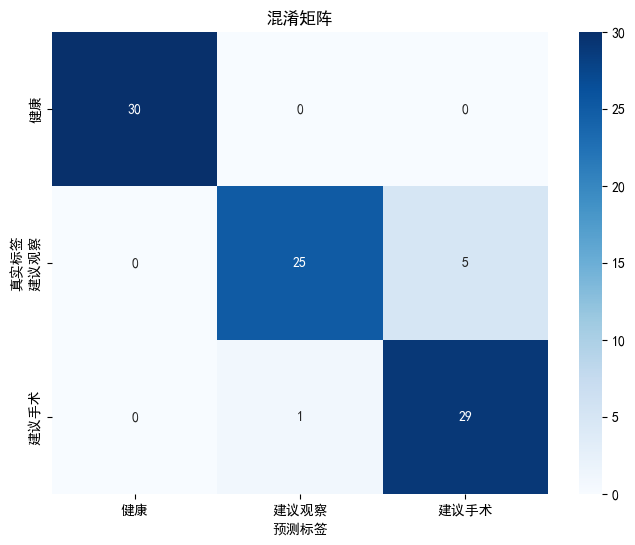

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score
import seaborn as sns

# 评估模型性能
model.eval()  # 设置模型为评估模式
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)

        # 获取预测结果
        _, predicted = outputs.max(1)
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 计算评估指标
accuracy = accuracy_score(all_targets, all_predictions)
macro_precision = precision_score(all_targets, all_predictions, average='macro')
macro_f1 = f1_score(all_targets, all_predictions, average='macro')
conf_matrix = confusion_matrix(all_targets, all_predictions)

print(f"验证集准确率: {accuracy:.4f}")
print(f"验证集Macro Precision: {macro_precision:.4f}")
print(f"验证集Macro F1分数: {macro_f1:.4f}")

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["健康", "建议观察", "建议手术"],
            yticklabels=["健康", "建议观察", "建议手术"])
plt.xlabel("预测标签")
plt.ylabel("真实标签")
plt.title("混淆矩阵")
plt.show()

# 模型保存和加载

In [11]:
# 保存模型参数
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"模型参数已保存到 {path}")

# 加载模型参数
def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    model = model.to(device)
    print(f"模型参数已从 {path} 加载")
    return model

# 保存训练好的模型
model_save_path = "./resnet18base_pterygium_classifier_base.pth"
save_model(model, model_save_path)

模型参数已保存到 ./resnet18base_pterygium_classifier_base.pth


# 模型测试和预测
使用训练好的模型对新图像进行预测，并展示几个预测示例。

In [12]:
# 模型测试和预测
def predict_image(model, image_path, transform, device):
    """
    使用训练好的模型对单张图像进行预测
    :param model: 训练好的模型
    :param image_path: 图像路径
    :param transform: 图像预处理变换
    :param device: 设备（CPU 或 GPU）
    :return: 预测类别
    """
    model.eval()  # 设置模型为评估模式
    image = Image.open(image_path).convert("RGB")  # 加载图像并转换为RGB
    image = transform(image).unsqueeze(0).to(device)  # 应用预处理并添加批次维度

    with torch.no_grad():
        outputs = model(image)  # 前向传播
        _, predicted = outputs.max(1)  # 获取预测类别
    return predicted.item()

def test_model_on_val(model, device, input_dir, temp_dir, transform):
    os.makedirs(temp_dir, exist_ok=True)
    image_paths = glob.glob(os.path.join(input_dir, "*.png"))
    # 删除临时目录中的旧文件
    for img_path in glob.glob(os.path.join(temp_dir, "*.png")):
        os.remove(img_path)
    results = []
    
    for img_path in tqdm(image_paths, desc="Processing images", leave=True):
        base_name = os.path.splitext(os.path.basename(img_path))[0]  # ...获取文件名（不带扩展）...
        output_path = os.path.join(temp_dir, f"{base_name}.{output_format.lower()}")
        if not os.path.exists(output_path):
            try:
                if resize_and_save_image({"Image": base_name}, input_dir, temp_dir, resize_transform, device):
                    predicted_class = predict_image(model, output_path, transform, device)
                    results.append({"Image": base_name, "Pterygium": predicted_class})
                else:
                    tqdm.write(f"Resize失败: {img_path}")
            except Exception as e:
                tqdm.write(f"处理图像 {img_path} 时出错: {e}")
    
    results.sort(key=lambda x: int(x["Image"]))
    df = pd.DataFrame(results, columns=["Image", "Pterygium"])
    result_path = os.path.join(kaggle_temp_path, "Classification_Results.xlsx")
    df.to_excel(result_path, index=False)
    print(f"分类结果已保存到 {result_path}")
    print(f'删除验证集缓存数据 {temp_dir}')
    for img_path in glob.glob(os.path.join(temp_dir, "*.png")):
        os.remove(img_path)

# 加载保存的模型并进行推理
loaded_model = ResNet18Classifier(num_classes=3)
loaded_model = load_model(loaded_model, model_save_path, device)

模型参数已从 ./resnet18base_pterygium_classifier_base.pth 加载


In [13]:
try:
    # 单文件推理
    test_image_path = "./test_images/sample_image.png"  # 替换为实际测试图像路径
    predicted_class = predict_image(loaded_model, test_image_path, val_transform, device)
    class_names = ["健康", "建议观察", "建议手术"]
    print(f"加载模型后预测结果: 图像 {os.path.basename(test_image_path)}, 预测类别: {class_names[predicted_class]}")
except:
    pass

In [14]:
# 验证集推理
val_temp_dir = os.path.join(kaggle_temp_path, "val_resized")
test_model_on_val(loaded_model, device, val_image_dir, val_temp_dir, val_transform)

Processing images:   0%|          | 0/150 [00:00<?, ?it/s]

分类结果已保存到 /kaggle/working/Classification_Results.xlsx
删除验证集缓存数据 /kaggle/working/val_resized


# 基线模型波动范围检测
为了理解模型性能的自然波动范围，我们将使用完全相同的设置重复训练过程10次。
每次运行都会重新初始化模型权重、优化器和早停策略。
我们将记录每次运行最终的验证集准确率和Macro F1分数，并计算平均值和标准差。
同时，我们也会保存每次运行的学习曲线（验证准确率随epoch的变化）并进行可视化。

**警告:** 这将花费大约10倍的单次训练时间！

开始进行 5 次独立训练运行以评估波动性...

--- 开始 Run 1/5 ---

--- Run 1/5: 开始训练 ---


Run 1/5 Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [1/25], Train Loss: 0.9246, Train Acc: 59.72%, Val Loss: 1.2975, Val Acc: 53.33%
EarlyStopping: Initialized best score to 53.3333


Run 1/5 Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [2/25], Train Loss: 0.5406, Train Acc: 76.94%, Val Loss: 1.7049, Val Acc: 55.56%
EarlyStopping: Improvement found. Best score updated to 55.5556. Counter reset.


Run 1/5 Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [3/25], Train Loss: 0.3657, Train Acc: 84.17%, Val Loss: 2.2974, Val Acc: 50.00%
EarlyStopping counter: 1 out of 7. Best score remains 55.5556.


Run 1/5 Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [4/25], Train Loss: 0.3215, Train Acc: 84.17%, Val Loss: 1.1210, Val Acc: 64.44%
EarlyStopping: Improvement found. Best score updated to 64.4444. Counter reset.


Run 1/5 Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [5/25], Train Loss: 0.2695, Train Acc: 88.61%, Val Loss: 0.7602, Val Acc: 78.89%
EarlyStopping: Improvement found. Best score updated to 78.8889. Counter reset.


Run 1/5 Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [6/25], Train Loss: 0.3358, Train Acc: 87.22%, Val Loss: 0.7094, Val Acc: 81.11%
EarlyStopping: Improvement found. Best score updated to 81.1111. Counter reset.


Run 1/5 Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [7/25], Train Loss: 0.2639, Train Acc: 89.72%, Val Loss: 0.5500, Val Acc: 88.89%
EarlyStopping: Improvement found. Best score updated to 88.8889. Counter reset.


Run 1/5 Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [8/25], Train Loss: 0.1563, Train Acc: 94.44%, Val Loss: 0.6992, Val Acc: 74.44%
EarlyStopping counter: 1 out of 7. Best score remains 88.8889.


Run 1/5 Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [9/25], Train Loss: 0.1396, Train Acc: 96.11%, Val Loss: 0.5877, Val Acc: 85.56%
EarlyStopping counter: 2 out of 7. Best score remains 88.8889.


Run 1/5 Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [10/25], Train Loss: 0.1201, Train Acc: 96.11%, Val Loss: 0.5038, Val Acc: 81.11%
EarlyStopping counter: 3 out of 7. Best score remains 88.8889.


Run 1/5 Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [11/25], Train Loss: 0.1352, Train Acc: 95.83%, Val Loss: 0.4209, Val Acc: 82.22%
EarlyStopping counter: 4 out of 7. Best score remains 88.8889.


Run 1/5 Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [12/25], Train Loss: 0.0833, Train Acc: 96.94%, Val Loss: 0.4838, Val Acc: 84.44%
EarlyStopping counter: 5 out of 7. Best score remains 88.8889.


Run 1/5 Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [13/25], Train Loss: 0.0845, Train Acc: 96.11%, Val Loss: 0.3395, Val Acc: 90.00%
EarlyStopping: Improvement found. Best score updated to 90.0000. Counter reset.


Run 1/5 Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [14/25], Train Loss: 0.0576, Train Acc: 98.06%, Val Loss: 0.4761, Val Acc: 86.67%
EarlyStopping counter: 1 out of 7. Best score remains 90.0000.


Run 1/5 Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [15/25], Train Loss: 0.0779, Train Acc: 97.78%, Val Loss: 0.3131, Val Acc: 92.22%
EarlyStopping: Improvement found. Best score updated to 92.2222. Counter reset.


Run 1/5 Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [16/25], Train Loss: 0.0645, Train Acc: 97.78%, Val Loss: 0.3528, Val Acc: 92.22%
EarlyStopping counter: 1 out of 7. Best score remains 92.2222.


Run 1/5 Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [17/25], Train Loss: 0.0471, Train Acc: 98.06%, Val Loss: 0.3679, Val Acc: 90.00%
EarlyStopping counter: 2 out of 7. Best score remains 92.2222.


Run 1/5 Epoch 18/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [18/25], Train Loss: 0.0404, Train Acc: 98.89%, Val Loss: 0.4042, Val Acc: 90.00%
EarlyStopping counter: 3 out of 7. Best score remains 92.2222.


Run 1/5 Epoch 19/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [19/25], Train Loss: 0.0301, Train Acc: 99.17%, Val Loss: 0.4175, Val Acc: 88.89%
EarlyStopping counter: 4 out of 7. Best score remains 92.2222.


Run 1/5 Epoch 20/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [20/25], Train Loss: 0.0266, Train Acc: 99.17%, Val Loss: 0.3835, Val Acc: 88.89%
EarlyStopping counter: 5 out of 7. Best score remains 92.2222.


Run 1/5 Epoch 21/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [21/25], Train Loss: 0.0186, Train Acc: 99.72%, Val Loss: 0.3600, Val Acc: 90.00%
EarlyStopping counter: 6 out of 7. Best score remains 92.2222.


Run 1/5 Epoch 22/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 1/5 Epoch [22/25], Train Loss: 0.0175, Train Acc: 99.72%, Val Loss: 0.3611, Val Acc: 90.00%
EarlyStopping counter: 7 out of 7. Best score remains 92.2222.
EarlyStopping: Patience reached.
Run 1/5: EarlyStopping triggered at epoch 22.
--- Run 1/5: 训练完成 ---
最终验证准确率: 92.2222%
最终验证Macro F1: 0.9218
本次运行耗时: 55.20 秒

--- 开始 Run 2/5 ---

--- Run 2/5: 开始训练 ---


Run 2/5 Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [1/25], Train Loss: 0.8485, Train Acc: 63.06%, Val Loss: 5.3562, Val Acc: 35.56%
EarlyStopping: Initialized best score to 35.5556


Run 2/5 Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [2/25], Train Loss: 0.6178, Train Acc: 77.50%, Val Loss: 3.5616, Val Acc: 41.11%
EarlyStopping: Improvement found. Best score updated to 41.1111. Counter reset.


Run 2/5 Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [3/25], Train Loss: 0.3420, Train Acc: 88.06%, Val Loss: 1.6336, Val Acc: 64.44%
EarlyStopping: Improvement found. Best score updated to 64.4444. Counter reset.


Run 2/5 Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [4/25], Train Loss: 0.3418, Train Acc: 87.22%, Val Loss: 2.2478, Val Acc: 61.11%
EarlyStopping counter: 1 out of 7. Best score remains 64.4444.


Run 2/5 Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [5/25], Train Loss: 0.2911, Train Acc: 90.00%, Val Loss: 2.0691, Val Acc: 68.89%
EarlyStopping: Improvement found. Best score updated to 68.8889. Counter reset.


Run 2/5 Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [6/25], Train Loss: 0.2139, Train Acc: 92.78%, Val Loss: 0.7282, Val Acc: 84.44%
EarlyStopping: Improvement found. Best score updated to 84.4444. Counter reset.


Run 2/5 Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [7/25], Train Loss: 0.2386, Train Acc: 91.11%, Val Loss: 0.7171, Val Acc: 80.00%
EarlyStopping counter: 1 out of 7. Best score remains 84.4444.


Run 2/5 Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [8/25], Train Loss: 0.2192, Train Acc: 92.50%, Val Loss: 0.7620, Val Acc: 83.33%
EarlyStopping counter: 2 out of 7. Best score remains 84.4444.


Run 2/5 Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [9/25], Train Loss: 0.1399, Train Acc: 95.28%, Val Loss: 0.7694, Val Acc: 80.00%
EarlyStopping counter: 3 out of 7. Best score remains 84.4444.


Run 2/5 Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [10/25], Train Loss: 0.1247, Train Acc: 95.00%, Val Loss: 0.4638, Val Acc: 88.89%
EarlyStopping: Improvement found. Best score updated to 88.8889. Counter reset.


Run 2/5 Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [11/25], Train Loss: 0.1078, Train Acc: 95.83%, Val Loss: 0.2913, Val Acc: 83.33%
EarlyStopping counter: 1 out of 7. Best score remains 88.8889.


Run 2/5 Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [12/25], Train Loss: 0.0810, Train Acc: 96.67%, Val Loss: 0.3407, Val Acc: 85.56%
EarlyStopping counter: 2 out of 7. Best score remains 88.8889.


Run 2/5 Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [13/25], Train Loss: 0.0703, Train Acc: 97.22%, Val Loss: 0.4667, Val Acc: 82.22%
EarlyStopping counter: 3 out of 7. Best score remains 88.8889.


Run 2/5 Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [14/25], Train Loss: 0.0543, Train Acc: 98.61%, Val Loss: 0.4675, Val Acc: 85.56%
EarlyStopping counter: 4 out of 7. Best score remains 88.8889.


Run 2/5 Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [15/25], Train Loss: 0.0304, Train Acc: 99.17%, Val Loss: 0.5584, Val Acc: 88.89%
EarlyStopping counter: 5 out of 7. Best score remains 88.8889.


Run 2/5 Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [16/25], Train Loss: 0.0499, Train Acc: 98.89%, Val Loss: 0.3428, Val Acc: 90.00%
EarlyStopping: Improvement found. Best score updated to 90.0000. Counter reset.


Run 2/5 Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [17/25], Train Loss: 0.0324, Train Acc: 99.17%, Val Loss: 0.2311, Val Acc: 91.11%
EarlyStopping: Improvement found. Best score updated to 91.1111. Counter reset.


Run 2/5 Epoch 18/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [18/25], Train Loss: 0.0257, Train Acc: 99.44%, Val Loss: 0.2681, Val Acc: 90.00%
EarlyStopping counter: 1 out of 7. Best score remains 91.1111.


Run 2/5 Epoch 19/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [19/25], Train Loss: 0.0137, Train Acc: 99.72%, Val Loss: 0.2738, Val Acc: 90.00%
EarlyStopping counter: 2 out of 7. Best score remains 91.1111.


Run 2/5 Epoch 20/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [20/25], Train Loss: 0.0162, Train Acc: 99.72%, Val Loss: 0.2967, Val Acc: 88.89%
EarlyStopping counter: 3 out of 7. Best score remains 91.1111.


Run 2/5 Epoch 21/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [21/25], Train Loss: 0.0256, Train Acc: 98.89%, Val Loss: 0.3249, Val Acc: 87.78%
EarlyStopping counter: 4 out of 7. Best score remains 91.1111.


Run 2/5 Epoch 22/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [22/25], Train Loss: 0.0242, Train Acc: 98.61%, Val Loss: 0.3324, Val Acc: 87.78%
EarlyStopping counter: 5 out of 7. Best score remains 91.1111.


Run 2/5 Epoch 23/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [23/25], Train Loss: 0.0193, Train Acc: 99.44%, Val Loss: 0.3303, Val Acc: 87.78%
EarlyStopping counter: 6 out of 7. Best score remains 91.1111.


Run 2/5 Epoch 24/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 2/5 Epoch [24/25], Train Loss: 0.0247, Train Acc: 99.44%, Val Loss: 0.3402, Val Acc: 87.78%
EarlyStopping counter: 7 out of 7. Best score remains 91.1111.
EarlyStopping: Patience reached.
Run 2/5: EarlyStopping triggered at epoch 24.
--- Run 2/5: 训练完成 ---
最终验证准确率: 91.1111%
最终验证Macro F1: 0.9107
本次运行耗时: 60.96 秒

--- 开始 Run 3/5 ---

--- Run 3/5: 开始训练 ---


Run 3/5 Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [1/25], Train Loss: 0.8562, Train Acc: 60.56%, Val Loss: 2.6264, Val Acc: 44.44%
EarlyStopping: Initialized best score to 44.4444


Run 3/5 Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [2/25], Train Loss: 0.5876, Train Acc: 77.50%, Val Loss: 1.6154, Val Acc: 70.00%
EarlyStopping: Improvement found. Best score updated to 70.0000. Counter reset.


Run 3/5 Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [3/25], Train Loss: 0.3914, Train Acc: 82.50%, Val Loss: 1.1105, Val Acc: 82.22%
EarlyStopping: Improvement found. Best score updated to 82.2222. Counter reset.


Run 3/5 Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [4/25], Train Loss: 0.2860, Train Acc: 89.44%, Val Loss: 0.9792, Val Acc: 77.78%
EarlyStopping counter: 1 out of 7. Best score remains 82.2222.


Run 3/5 Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [5/25], Train Loss: 0.2501, Train Acc: 90.28%, Val Loss: 1.4417, Val Acc: 70.00%
EarlyStopping counter: 2 out of 7. Best score remains 82.2222.


Run 3/5 Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [6/25], Train Loss: 0.2402, Train Acc: 91.11%, Val Loss: 1.1402, Val Acc: 75.56%
EarlyStopping counter: 3 out of 7. Best score remains 82.2222.


Run 3/5 Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [7/25], Train Loss: 0.1807, Train Acc: 93.89%, Val Loss: 0.6777, Val Acc: 85.56%
EarlyStopping: Improvement found. Best score updated to 85.5556. Counter reset.


Run 3/5 Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [8/25], Train Loss: 0.1892, Train Acc: 92.78%, Val Loss: 0.4563, Val Acc: 86.67%
EarlyStopping: Improvement found. Best score updated to 86.6667. Counter reset.


Run 3/5 Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [9/25], Train Loss: 0.2272, Train Acc: 91.11%, Val Loss: 0.9186, Val Acc: 71.11%
EarlyStopping counter: 1 out of 7. Best score remains 86.6667.


Run 3/5 Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [10/25], Train Loss: 0.1335, Train Acc: 94.44%, Val Loss: 0.7412, Val Acc: 84.44%
EarlyStopping counter: 2 out of 7. Best score remains 86.6667.


Run 3/5 Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [11/25], Train Loss: 0.1311, Train Acc: 95.28%, Val Loss: 0.5213, Val Acc: 81.11%
EarlyStopping counter: 3 out of 7. Best score remains 86.6667.


Run 3/5 Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [12/25], Train Loss: 0.0825, Train Acc: 96.94%, Val Loss: 0.4470, Val Acc: 81.11%
EarlyStopping counter: 4 out of 7. Best score remains 86.6667.


Run 3/5 Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [13/25], Train Loss: 0.0787, Train Acc: 96.94%, Val Loss: 0.4670, Val Acc: 88.89%
EarlyStopping: Improvement found. Best score updated to 88.8889. Counter reset.


Run 3/5 Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [14/25], Train Loss: 0.0699, Train Acc: 97.50%, Val Loss: 0.3328, Val Acc: 88.89%
EarlyStopping counter: 1 out of 7. Best score remains 88.8889.


Run 3/5 Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [15/25], Train Loss: 0.0520, Train Acc: 97.78%, Val Loss: 0.3477, Val Acc: 86.67%
EarlyStopping counter: 2 out of 7. Best score remains 88.8889.


Run 3/5 Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [16/25], Train Loss: 0.0407, Train Acc: 98.61%, Val Loss: 0.4081, Val Acc: 87.78%
EarlyStopping counter: 3 out of 7. Best score remains 88.8889.


Run 3/5 Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [17/25], Train Loss: 0.0418, Train Acc: 98.33%, Val Loss: 0.3891, Val Acc: 88.89%
EarlyStopping counter: 4 out of 7. Best score remains 88.8889.


Run 3/5 Epoch 18/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [18/25], Train Loss: 0.0579, Train Acc: 97.78%, Val Loss: 0.3245, Val Acc: 88.89%
EarlyStopping counter: 5 out of 7. Best score remains 88.8889.


Run 3/5 Epoch 19/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [19/25], Train Loss: 0.0434, Train Acc: 98.06%, Val Loss: 0.2997, Val Acc: 90.00%
EarlyStopping: Improvement found. Best score updated to 90.0000. Counter reset.


Run 3/5 Epoch 20/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [20/25], Train Loss: 0.0240, Train Acc: 99.72%, Val Loss: 0.3003, Val Acc: 90.00%
EarlyStopping counter: 1 out of 7. Best score remains 90.0000.


Run 3/5 Epoch 21/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [21/25], Train Loss: 0.0266, Train Acc: 99.44%, Val Loss: 0.3075, Val Acc: 90.00%
EarlyStopping counter: 2 out of 7. Best score remains 90.0000.


Run 3/5 Epoch 22/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [22/25], Train Loss: 0.0167, Train Acc: 99.72%, Val Loss: 0.3087, Val Acc: 90.00%
EarlyStopping counter: 3 out of 7. Best score remains 90.0000.


Run 3/5 Epoch 23/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [23/25], Train Loss: 0.0370, Train Acc: 99.44%, Val Loss: 0.3257, Val Acc: 90.00%
EarlyStopping counter: 4 out of 7. Best score remains 90.0000.


Run 3/5 Epoch 24/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [24/25], Train Loss: 0.0127, Train Acc: 99.72%, Val Loss: 0.3205, Val Acc: 90.00%
EarlyStopping counter: 5 out of 7. Best score remains 90.0000.


Run 3/5 Epoch 25/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 3/5 Epoch [25/25], Train Loss: 0.0224, Train Acc: 99.72%, Val Loss: 0.3176, Val Acc: 90.00%
EarlyStopping counter: 6 out of 7. Best score remains 90.0000.
Run 3/5: Training finished after 25 epochs.
--- Run 3/5: 训练完成 ---
最终验证准确率: 90.0000%
最终验证Macro F1: 0.8992
本次运行耗时: 63.61 秒

--- 开始 Run 4/5 ---

--- Run 4/5: 开始训练 ---


Run 4/5 Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [1/25], Train Loss: 0.8615, Train Acc: 57.78%, Val Loss: 2.1148, Val Acc: 43.33%
EarlyStopping: Initialized best score to 43.3333


Run 4/5 Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [2/25], Train Loss: 0.5480, Train Acc: 75.00%, Val Loss: 1.7893, Val Acc: 57.78%
EarlyStopping: Improvement found. Best score updated to 57.7778. Counter reset.


Run 4/5 Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [3/25], Train Loss: 0.4801, Train Acc: 80.83%, Val Loss: 0.8180, Val Acc: 77.78%
EarlyStopping: Improvement found. Best score updated to 77.7778. Counter reset.


Run 4/5 Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [4/25], Train Loss: 0.3195, Train Acc: 85.56%, Val Loss: 1.1530, Val Acc: 73.33%
EarlyStopping counter: 1 out of 7. Best score remains 77.7778.


Run 4/5 Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [5/25], Train Loss: 0.2501, Train Acc: 91.11%, Val Loss: 0.9344, Val Acc: 81.11%
EarlyStopping: Improvement found. Best score updated to 81.1111. Counter reset.


Run 4/5 Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [6/25], Train Loss: 0.2394, Train Acc: 92.22%, Val Loss: 0.7457, Val Acc: 80.00%
EarlyStopping counter: 1 out of 7. Best score remains 81.1111.


Run 4/5 Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [7/25], Train Loss: 0.1996, Train Acc: 93.89%, Val Loss: 0.5717, Val Acc: 85.56%
EarlyStopping: Improvement found. Best score updated to 85.5556. Counter reset.


Run 4/5 Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [8/25], Train Loss: 0.1414, Train Acc: 93.89%, Val Loss: 0.4926, Val Acc: 81.11%
EarlyStopping counter: 1 out of 7. Best score remains 85.5556.


Run 4/5 Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [9/25], Train Loss: 0.1556, Train Acc: 94.72%, Val Loss: 1.0257, Val Acc: 74.44%
EarlyStopping counter: 2 out of 7. Best score remains 85.5556.


Run 4/5 Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [10/25], Train Loss: 0.1068, Train Acc: 95.00%, Val Loss: 0.7442, Val Acc: 84.44%
EarlyStopping counter: 3 out of 7. Best score remains 85.5556.


Run 4/5 Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [11/25], Train Loss: 0.1406, Train Acc: 95.00%, Val Loss: 0.6464, Val Acc: 87.78%
EarlyStopping: Improvement found. Best score updated to 87.7778. Counter reset.


Run 4/5 Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [12/25], Train Loss: 0.0729, Train Acc: 97.78%, Val Loss: 0.5178, Val Acc: 86.67%
EarlyStopping counter: 1 out of 7. Best score remains 87.7778.


Run 4/5 Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [13/25], Train Loss: 0.0994, Train Acc: 97.22%, Val Loss: 0.4451, Val Acc: 87.78%
EarlyStopping counter: 2 out of 7. Best score remains 87.7778.


Run 4/5 Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [14/25], Train Loss: 0.0552, Train Acc: 98.89%, Val Loss: 0.5168, Val Acc: 88.89%
EarlyStopping: Improvement found. Best score updated to 88.8889. Counter reset.


Run 4/5 Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [15/25], Train Loss: 0.0656, Train Acc: 98.06%, Val Loss: 0.4725, Val Acc: 87.78%
EarlyStopping counter: 1 out of 7. Best score remains 88.8889.


Run 4/5 Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [16/25], Train Loss: 0.0516, Train Acc: 98.33%, Val Loss: 0.5134, Val Acc: 86.67%
EarlyStopping counter: 2 out of 7. Best score remains 88.8889.


Run 4/5 Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [17/25], Train Loss: 0.0372, Train Acc: 98.89%, Val Loss: 0.4800, Val Acc: 87.78%
EarlyStopping counter: 3 out of 7. Best score remains 88.8889.


Run 4/5 Epoch 18/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [18/25], Train Loss: 0.0196, Train Acc: 99.44%, Val Loss: 0.4727, Val Acc: 90.00%
EarlyStopping: Improvement found. Best score updated to 90.0000. Counter reset.


Run 4/5 Epoch 19/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [19/25], Train Loss: 0.0210, Train Acc: 99.44%, Val Loss: 0.4504, Val Acc: 90.00%
EarlyStopping counter: 1 out of 7. Best score remains 90.0000.


Run 4/5 Epoch 20/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [20/25], Train Loss: 0.0184, Train Acc: 100.00%, Val Loss: 0.4131, Val Acc: 88.89%
EarlyStopping counter: 2 out of 7. Best score remains 90.0000.


Run 4/5 Epoch 21/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [21/25], Train Loss: 0.0204, Train Acc: 100.00%, Val Loss: 0.3867, Val Acc: 88.89%
EarlyStopping counter: 3 out of 7. Best score remains 90.0000.


Run 4/5 Epoch 22/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [22/25], Train Loss: 0.0261, Train Acc: 98.61%, Val Loss: 0.3710, Val Acc: 88.89%
EarlyStopping counter: 4 out of 7. Best score remains 90.0000.


Run 4/5 Epoch 23/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [23/25], Train Loss: 0.0165, Train Acc: 99.72%, Val Loss: 0.3708, Val Acc: 88.89%
EarlyStopping counter: 5 out of 7. Best score remains 90.0000.


Run 4/5 Epoch 24/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [24/25], Train Loss: 0.0183, Train Acc: 99.17%, Val Loss: 0.3733, Val Acc: 88.89%
EarlyStopping counter: 6 out of 7. Best score remains 90.0000.


Run 4/5 Epoch 25/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 4/5 Epoch [25/25], Train Loss: 0.0158, Train Acc: 99.72%, Val Loss: 0.3762, Val Acc: 88.89%
EarlyStopping counter: 7 out of 7. Best score remains 90.0000.
EarlyStopping: Patience reached.
Run 4/5: EarlyStopping triggered at epoch 25.
--- Run 4/5: 训练完成 ---
最终验证准确率: 90.0000%
最终验证Macro F1: 0.9008
本次运行耗时: 63.54 秒

--- 开始 Run 5/5 ---

--- Run 5/5: 开始训练 ---


Run 5/5 Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [1/25], Train Loss: 0.9573, Train Acc: 57.50%, Val Loss: 6.0146, Val Acc: 36.67%
EarlyStopping: Initialized best score to 36.6667


Run 5/5 Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [2/25], Train Loss: 0.7010, Train Acc: 73.33%, Val Loss: 2.3460, Val Acc: 64.44%
EarlyStopping: Improvement found. Best score updated to 64.4444. Counter reset.


Run 5/5 Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [3/25], Train Loss: 0.5389, Train Acc: 77.22%, Val Loss: 3.6035, Val Acc: 47.78%
EarlyStopping counter: 1 out of 7. Best score remains 64.4444.


Run 5/5 Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [4/25], Train Loss: 0.3745, Train Acc: 84.17%, Val Loss: 0.9759, Val Acc: 73.33%
EarlyStopping: Improvement found. Best score updated to 73.3333. Counter reset.


Run 5/5 Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [5/25], Train Loss: 0.2729, Train Acc: 88.61%, Val Loss: 0.7868, Val Acc: 83.33%
EarlyStopping: Improvement found. Best score updated to 83.3333. Counter reset.


Run 5/5 Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [6/25], Train Loss: 0.2490, Train Acc: 90.56%, Val Loss: 1.0317, Val Acc: 76.67%
EarlyStopping counter: 1 out of 7. Best score remains 83.3333.


Run 5/5 Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [7/25], Train Loss: 0.1664, Train Acc: 93.61%, Val Loss: 1.2629, Val Acc: 72.22%
EarlyStopping counter: 2 out of 7. Best score remains 83.3333.


Run 5/5 Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [8/25], Train Loss: 0.1137, Train Acc: 95.56%, Val Loss: 0.6727, Val Acc: 84.44%
EarlyStopping: Improvement found. Best score updated to 84.4444. Counter reset.


Run 5/5 Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [9/25], Train Loss: 0.1460, Train Acc: 94.17%, Val Loss: 0.5135, Val Acc: 83.33%
EarlyStopping counter: 1 out of 7. Best score remains 84.4444.


Run 5/5 Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [10/25], Train Loss: 0.1731, Train Acc: 94.44%, Val Loss: 0.6737, Val Acc: 81.11%
EarlyStopping counter: 2 out of 7. Best score remains 84.4444.


Run 5/5 Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [11/25], Train Loss: 0.1142, Train Acc: 94.72%, Val Loss: 0.6092, Val Acc: 78.89%
EarlyStopping counter: 3 out of 7. Best score remains 84.4444.


Run 5/5 Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [12/25], Train Loss: 0.1390, Train Acc: 93.89%, Val Loss: 0.5052, Val Acc: 83.33%
EarlyStopping counter: 4 out of 7. Best score remains 84.4444.


Run 5/5 Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [13/25], Train Loss: 0.0553, Train Acc: 98.89%, Val Loss: 0.4465, Val Acc: 87.78%
EarlyStopping: Improvement found. Best score updated to 87.7778. Counter reset.


Run 5/5 Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [14/25], Train Loss: 0.0978, Train Acc: 96.11%, Val Loss: 0.4647, Val Acc: 82.22%
EarlyStopping counter: 1 out of 7. Best score remains 87.7778.


Run 5/5 Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [15/25], Train Loss: 0.0717, Train Acc: 96.94%, Val Loss: 0.4948, Val Acc: 85.56%
EarlyStopping counter: 2 out of 7. Best score remains 87.7778.


Run 5/5 Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [16/25], Train Loss: 0.0281, Train Acc: 99.17%, Val Loss: 0.5213, Val Acc: 85.56%
EarlyStopping counter: 3 out of 7. Best score remains 87.7778.


Run 5/5 Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [17/25], Train Loss: 0.0533, Train Acc: 98.89%, Val Loss: 0.3886, Val Acc: 87.78%
EarlyStopping counter: 4 out of 7. Best score remains 87.7778.


Run 5/5 Epoch 18/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [18/25], Train Loss: 0.0468, Train Acc: 97.78%, Val Loss: 0.3822, Val Acc: 85.56%
EarlyStopping counter: 5 out of 7. Best score remains 87.7778.


Run 5/5 Epoch 19/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [19/25], Train Loss: 0.0255, Train Acc: 99.44%, Val Loss: 0.4208, Val Acc: 83.33%
EarlyStopping counter: 6 out of 7. Best score remains 87.7778.


Run 5/5 Epoch 20/25:   0%|          | 0/6 [00:00<?, ?it/s]

Run 5/5 Epoch [20/25], Train Loss: 0.0516, Train Acc: 98.33%, Val Loss: 0.3584, Val Acc: 87.78%
EarlyStopping counter: 7 out of 7. Best score remains 87.7778.
EarlyStopping: Patience reached.
Run 5/5: EarlyStopping triggered at epoch 20.
--- Run 5/5: 训练完成 ---
最终验证准确率: 87.7778%
最终验证Macro F1: 0.8775
本次运行耗时: 50.84 秒

--- 多次运行结果分析 ---
平均验证准确率: 90.2222%
验证准确率标准差: 1.4741%
平均验证Macro F1: 0.9020
验证Macro F1标准差: 0.0147

每次运行的最终验证准确率:
  Run 1: 92.2222%
  Run 2: 91.1111%
  Run 3: 90.0000%
  Run 4: 90.0000%
  Run 5: 87.7778%

每次运行的最终验证Macro F1:
  Run 1: 0.9218
  Run 2: 0.9107
  Run 3: 0.8992
  Run 4: 0.9008
  Run 5: 0.8775


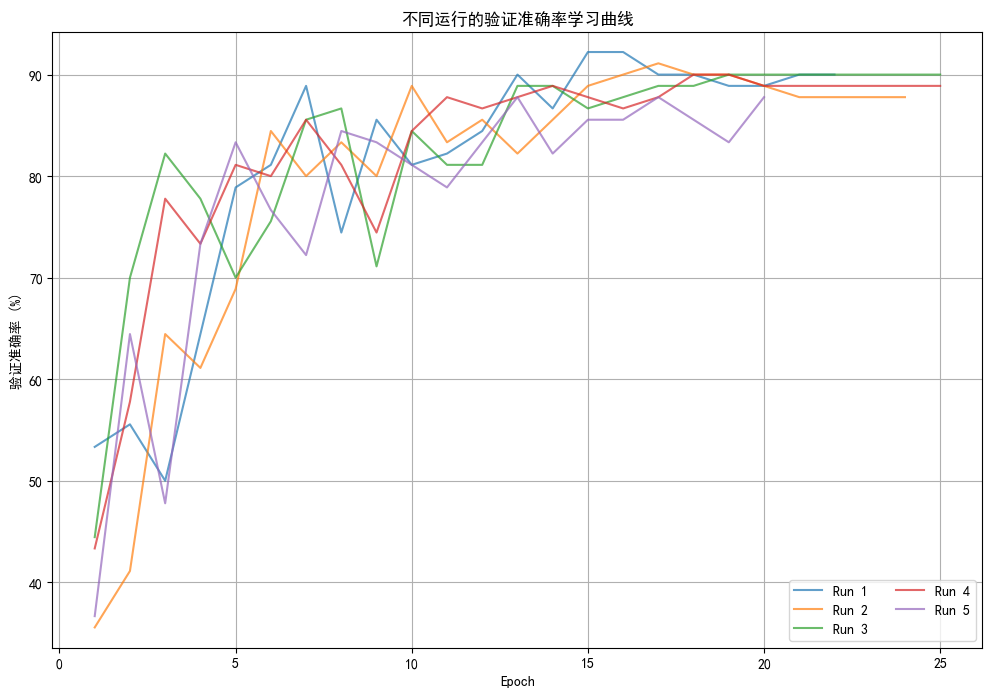

In [15]:
# --- 实验参数 ---
num_runs = 5  # 重复运行的次数
base_seed = 42 # 基础随机种子，每次运行会递增

# --- 存储结果 ---
all_final_val_accuracies = []
all_final_macro_f1_scores = []
all_learning_curves = [] # 存储每个run的验证准确率历史
# best_model_state_dicts = [] # 如果需要保存每次运行的最佳模型权重

# --- 定义损失函数 (可以在循环外定义，因为无状态) ---
base_loss_fn = nn.CrossEntropyLoss()
# 注意：确保 HighlightRegularizedLoss 类已经定义
criterion = HighlightRegularizedLoss(base_loss_fn=base_loss_fn, lambda_reg=0.01) # 再次注意：正则项仍未启用

# --- 开始多次运行循环 ---
print(f"开始进行 {num_runs} 次独立训练运行以评估波动性...")

for run in range(num_runs):
    run_id_str = f"Run {run + 1}/{num_runs}"
    print(f"\n--- 开始 {run_id_str} ---")

    # --- 1. 设置随机种子 ---
    current_seed = base_seed + run
    torch.manual_seed(current_seed)
    np.random.seed(current_seed)
    random.seed(current_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(current_seed)
        # 下面两行可确保重复性，但是降低性能
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

    # --- 2. 创建此运行所需的模型、优化器和调度器实例 ---
    # **每次循环都必须创建新的实例**
    model = ResNet18Classifier(num_classes=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=7e-4, weight_decay=1e-4) # 使用基线超参数
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6) # 使用基线超参数
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)
    
    # --- 3. 调用训练函数 ---
    # train_loader 和 val_loader 是之前已经定义好的
    final_acc, final_f1, history, best_state = train_validate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        device=device,
        run_identifier=run_id_str
    )

    # --- 4. 存储结果 ---
    all_final_val_accuracies.append(final_acc)
    all_final_macro_f1_scores.append(final_f1)
    all_learning_curves.append(history)
    # if best_state: # 如果需要保存权重
    #     best_model_state_dicts.append(best_state)

# --- 5. 多次运行结束后，进行分析和可视化 ---
print("\n--- 多次运行结果分析 ---")

# 计算平均值和标准差
mean_accuracy = np.mean(all_final_val_accuracies)
std_accuracy = np.std(all_final_val_accuracies)
mean_f1 = np.mean(all_final_macro_f1_scores)
std_f1 = np.std(all_final_macro_f1_scores)

print(f"平均验证准确率: {mean_accuracy:.4f}%")
print(f"验证准确率标准差: {std_accuracy:.4f}%")
print(f"平均验证Macro F1: {mean_f1:.4f}")
print(f"验证Macro F1标准差: {std_f1:.4f}")

print("\n每次运行的最终验证准确率:")
for i, acc in enumerate(all_final_val_accuracies):
    print(f"  Run {i+1}: {acc:.4f}%")

print("\n每次运行的最终验证Macro F1:")
for i, f1 in enumerate(all_final_macro_f1_scores):
    print(f"  Run {i+1}: {f1:.4f}")

# --- 6. 可视化学习曲线 (与之前相同) ---
plt.figure(figsize=(12, 8))
for i, curve in enumerate(all_learning_curves):
    epochs_run = range(1, len(curve) + 1)
    plt.plot(epochs_run, curve, label=f'Run {i+1}', alpha=0.7)

plt.title('不同运行的验证准确率学习曲线')
plt.xlabel('Epoch')
plt.ylabel('验证准确率 (%)')
plt.legend(loc='lower right', ncol=2)
plt.grid(True)
# 动态调整Y轴范围，确保所有曲线可见
min_y_val = np.min([min(c) for c in all_learning_curves if c]) if any(all_learning_curves) else 80 # 如果有数据则取最小值，否则默认80
max_y_val = np.max([max(c) for c in all_learning_curves if c]) if any(all_learning_curves) else 100 # 如果有数据则取最大值，否则默认100
plt.ylim(bottom=max(0, min_y_val - 2), top=min(100, max_y_val + 2)) # 确保在[0, 100]范围内，并留出边距
plt.show()